In [1]:
import h5py
import os
import random
import sklearn
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from utils import random_color_generator
import plotting
## seance 2
import umap
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC

## TP5 Introduction aux techniques d'apprentissage profond sur des donnees de cancer
#### Important: prière d'exécuter les cellules dans l'ordre ou redémarrer le noyau :) 
### Importation des donnees et visualisation 


In [5]:
inpath = "/cours/a23_bin3002-a/cours/TP6/TCGA_TPM_hv_subset.h5"
inf = h5py.File(inpath, "r")

In [6]:
tpm_data = inf['data'][:,:] 

In [7]:
gene_names = inf['rows'][:]
sample_ids = inf['cols'][:]
labels =np.array(inf["labels"][:], dtype=str)

### Visualisation avec t-SNE

In [8]:
tsne = TSNE(init = 'pca', n_iter = 2000)
X_tr_tsne = tsne.fit_transform(tpm_data.T)
plotting.plot_tsne(X_tr_tsne, labels)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10346 samples in 1.889s...
[t-SNE] Computed neighbors for 10346 samples in 13.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10346
[t-SNE] Computed conditional probabilities for sample 2000 / 10346
[t-SNE] Computed conditional probabilities for sample 3000 / 10346
[t-SNE] Computed conditional probabilities for sample 4000 / 10346
[t-SNE] Computed conditional probabilities for sample 5000 / 10346
[t-SNE] Computed conditional probabilities for sample 6000 / 10346
[t-SNE] Computed conditional probabilities for sample 7000 / 10346
[t-SNE] Computed conditional probabilities for sample 8000 / 10346
[t-SNE] Computed conditional probabilities for sample 9000 / 10346
[t-SNE] Computed conditional probabilities for sample 10000 / 10346
[t-SNE] Computed conditional probabilities for sample 10346 / 10346
[t-SNE] Mean sigma: 10.083168
[t-SNE] Computed conditional probabilities in 0.381s
[t-SNE] Iteration 50: error = 83.6

### Entrainement d'un reseau de neurone
#### Preparation des donnees

In [34]:
import torch
from torch import nn

In [8]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]

#### Exemple d'entrainement de la classification des types de cancer avec 1 fold

In [35]:
### fonction d'initialisation du reseau
def model(insize, outsize, width=100):
    return nn.Sequential(
    nn.Linear(insize,width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, outsize))

In [36]:
def train(nepochs = 100, printstep=10, wd = 1e-3):
    DNN = model(insize, outsize)
    optimizer = torch.optim.Adam(DNN.parameters(), lr = 0.0001, weight_decay = wd)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.cross_entropy(y_tr_out, Y_train) # loss computation
        tst_loss = nn.functional.cross_entropy(y_tst_out, Y_test) # Softmax -> NLL
        
        tr_acc = np.array(y_tr_out.max(1).indices == Y_train.max(1).indices,dtype=int).mean() # accuracy metrics
        tst_acc = np.array(y_tst_out.max(1).indices == Y_test.max(1).indices,dtype=int).mean()
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),2)} - acc : {round(float(tr_acc),2)} Test acc : {round(tst_acc,2)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [11]:
mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 100)

Loss 0 Train - loss : 3.51 - acc : 0.05 Test acc : 0.05
Loss 100 Train - loss : 0.5 - acc : 0.9 Test acc : 0.9
Loss 200 Train - loss : 0.2 - acc : 0.95 Test acc : 0.94
Loss 300 Train - loss : 0.12 - acc : 0.97 Test acc : 0.95
Loss 400 Train - loss : 0.08 - acc : 0.99 Test acc : 0.95
Loss 500 Train - loss : 0.05 - acc : 0.99 Test acc : 0.96
Loss 600 Train - loss : 0.04 - acc : 1.0 Test acc : 0.96
Loss 700 Train - loss : 0.03 - acc : 1.0 Test acc : 0.96


#### Plot learning curves

In [ ]:
steps = np.arange(len(trl))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
axes[0].plot(steps, trl, label = "train")
axes[0].plot(steps, tstl, label= "test")
axes[1].plot(steps, trc * 100, label = "train")
axes[1].plot(steps, tstc * 100, label= "test")
axes[0].set_ylabel("CrossEntropyLoss")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim((0,100))
axes[1].set_xlabel("Gradient step")
axes[0].legend()
axes[0].set_title(f"Learning curves of DNN on classification of cancer type in TCGA data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")
plt.savefig("DNN_learning_curves.pdf")

#### Plot final accuracy with confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_tr_out = np.array(mm(X_train).max(1).indices)
y_tr_true = np.array(Y_train.max(1).indices)
y_tst_out = np.array([np.unique(labels)[x] for x in mm(X_test).max(1).indices])
y_tst_true = np.array([np.unique(labels)[x] for x in Y_test.max(1).indices])
cm = confusion_matrix(y_tst_true, y_tst_out, labels =  np.unique(labels))
print(f"Accuracy on train set (n = {X_train.shape[0]}): {round((np.mean( y_tr_out== y_tr_true)),4) * 100}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {round((np.mean(y_tst_out == y_tst_true)),4) * 100}%")
print(f"Number of errors : {(np.sum(y_tst_out != y_tst_true)) }")


In [ ]:
import seaborn as sn
import itertools

In [ ]:
#df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (10,10))
ax = plt.imshow(cm, interpolation = "nearest", cmap = plt.get_cmap('Blues'))
#ax.set_ylim(0, 3) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
#ax.invert_yaxis() #optional
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        
tick_marks = np.arange(len(np.unique(labels)))
plt.xticks(tick_marks, np.unique(labels), rotation=45)
plt.yticks(tick_marks, np.unique(labels))
plt.title(f"Classifier DNN confusion matrix results on TCGA Test set nb errors")
plt.savefig("DNN_TEST_CM.pdf")

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
log_clf = RidgeClassifier(alpha = 1e-4, solver = "lsqr", max_iter = 100)
log_clf.fit(X_train, Y_train)

In [ ]:
print(f"Accuracy on train set (n = {X_train.shape[0]}): {round((np.mean(log_clf.predict(X_train) == Y_train)),4) * 100}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {round((np.mean(log_clf.predict(X_test) == Y_test)),4) * 100}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")


In [ ]:
y_tst_out = log_clf.predict(X_test)
y_tst_true = Y_test
cm = confusion_matrix(y_tst_true, y_tst_out, labels =  np.unique(labels))
#df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize = (10,10))
ax = plt.imshow(cm, interpolation = "nearest", cmap = plt.get_cmap('Blues'))
#ax.set_ylim(0, 3) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
#ax.invert_yaxis() #optional
thresh = cm.max() / 1.5
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        
tick_marks = np.arange(len(np.unique(labels)))
plt.xticks(tick_marks, np.unique(labels), rotation=45)
plt.yticks(tick_marks, np.unique(labels))
plt.savefig("LOG_CLF_TEST_CM.pdf")

## III. Classification de sous-types de cancers du sein et comparaison de methodes entre la regression logistique regularisee et un modele d'apprentissage profond.

In [ ]:
# importation des donnees
dataset = h5py.File("TCGA_BRCA_fpkm_hv_norm_PAM50.h5","r")
tpm_data = dataset['data'][:,:] 
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str)

In [ ]:
tsne = TSNE(verbose = 5, init = 'pca', n_iter = 2000)
X_tr_tsne = tsne.fit_transform(tpm_data.T)

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 7))
ax1.grid(visible=True,linestyle="--")
ax1.set_axisbelow(True)
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
for (i,lbl) in enumerate(np.unique(labels)):
    #defin_ = tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0] 
    #count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
    #tag = f"{defin_} ({count_})"
    #print(X_tr_tsne[labels ==lbl,0])
    ax1.scatter(X_tr_tsne[labels ==lbl,0], 
                X_tr_tsne[labels ==lbl,1], 
                s = 8, marker=markers_[i], label = lbl)
ax1.axis("equal")
ax1.legend(bbox_to_anchor=(1,1),fontsize = 8)
ax1.set_xlabel("TSNE1")
ax1.set_ylabel("TSNE2")
plt.tight_layout()
plt.savefig("figTSNE.pdf")

In [ ]:

# classification avec RidgeClassifier
logclf_acc,nb_rep = [],50
for i in range(nb_rep):
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
    log_clf = RidgeClassifier(alpha = 1e-3, solver = "lsqr", max_iter = 1000)
    log_clf.fit(X_train, Y_train)
    logclf_acc.append(np.mean(log_clf.predict(X_test) == Y_test))

print(f"Accuracy on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(logclf_acc)),4) * 100} +/- {round(np.std(logclf_acc),4)} %")


In [ ]:
# classification avec DNN
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]
dnnclf_acc,nb_rep = [],10
for i in range(nb_rep):
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 1000, wd = 1e-2)
    dnnclf_acc.append(tstc[-1])
print(f"Accuracy DNN on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(dnnclf_acc)) * 100,2) } +/- {round(np.std(dnnclf_acc) * 100,2)} %")


In [25]:
# importation des donnees
dataset = h5py.File("TARGET_ALL_264_norm_tpm_lab.h5","r")
tpm_data = dataset['data'][:,:] 
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str)

In [26]:
tpm_data.shape

(60660, 264)

In [27]:
tsne = TSNE(init = "pca", perplexity =20, n_iter = 2000)
X_tr_tsne = tsne.fit_transform(tpm_data.T)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.089s...
[t-SNE] Computed neighbors for 264 samples in 7.237s...
[t-SNE] Computed conditional probabilities for sample 264 / 264
[t-SNE] Mean sigma: 20.048939
[t-SNE] Computed conditional probabilities in 0.009s
[t-SNE] Iteration 50: error = 61.0316734, gradient norm = 0.2157724 (50 iterations in 0.113s)
[t-SNE] Iteration 100: error = 60.2924385, gradient norm = 0.3404995 (50 iterations in 0.043s)
[t-SNE] Iteration 150: error = 63.0130196, gradient norm = 0.2221746 (50 iterations in 0.043s)
[t-SNE] Iteration 200: error = 60.6599731, gradient norm = 0.4840694 (50 iterations in 0.043s)
[t-SNE] Iteration 250: error = 61.6030540, gradient norm = 0.2232863 (50 iterations in 0.043s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.603054
[t-SNE] Iteration 300: error = 1.0611410, gradient norm = 0.0087544 (50 iterations in 0.042s)
[t-SNE] Iteration 350: error = 1.0190618, gradient norm = 0.0040797 

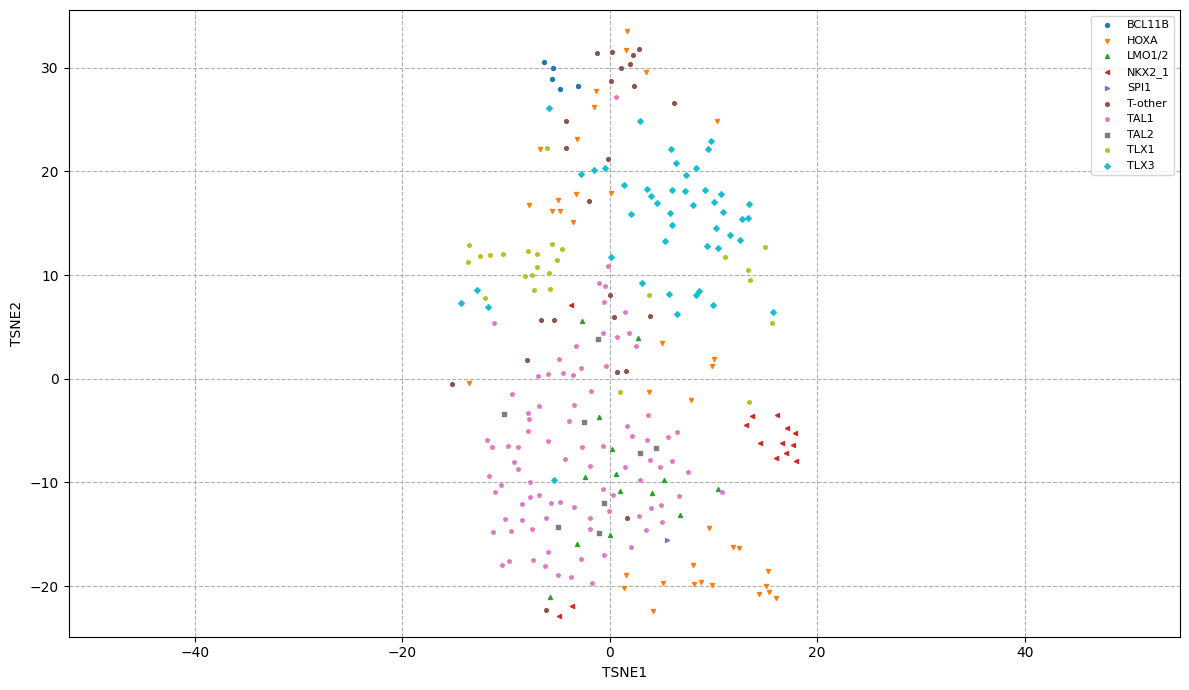

In [31]:
import plotting
plotting.plot_tsne(X_tr_tsne, labels)

In [32]:
# classification avec RidgeClassifier
logclf_acc,nb_rep = [],50
for i in range(nb_rep):
    X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)
    log_clf = RidgeClassifier(alpha = 1e-3, solver = "lsqr", max_iter = 1000)
    log_clf.fit(X_train, Y_train)
    logclf_acc.append(np.mean(log_clf.predict(X_test) == Y_test))

print(f"Accuracy on test set \n(nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(logclf_acc)),4) * 100} +/- {round(np.std(logclf_acc),4)} %")


Accuracy on test set 
(nb of replicates = 50,  n samples test = 53): 82.15 +/- 0.0461 %


In [ ]:
import torch
import torch.nn as nn

In [38]:
# classification avec DNN
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables
outsize = Y_train.shape[1]
dnnclf_acc,nb_rep = [],10
for i in range(nb_rep):
    X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
    mm, trl, tstl, trc, tstc = train(nepochs = 1000, printstep = 1000, wd = 1e-2)
    dnnclf_acc.append(tstc[-1])
print(f"Accuracy DNN on test set (nb of replicates = {nb_rep},  n samples test = {X_test.shape[0]}): {round((np.mean(dnnclf_acc)) * 100,2) } +/- {round(np.std(dnnclf_acc) * 100,2)} %")


Loss 0 Train - loss : 2.25 - acc : 0.36 Test acc : 0.26
Loss 999 Train - loss : 0.09 - acc : 1.0 Test acc : 0.72
Loss 0 Train - loss : 2.22 - acc : 0.32 Test acc : 0.42
Loss 999 Train - loss : 0.08 - acc : 1.0 Test acc : 0.79
Loss 0 Train - loss : 2.26 - acc : 0.35 Test acc : 0.32
Loss 999 Train - loss : 0.08 - acc : 1.0 Test acc : 0.77
Loss 0 Train - loss : 2.29 - acc : 0.12 Test acc : 0.13
Loss 999 Train - loss : 0.09 - acc : 1.0 Test acc : 0.81
Loss 0 Train - loss : 2.31 - acc : 0.03 Test acc : 0.04
Loss 999 Train - loss : 0.09 - acc : 1.0 Test acc : 0.72
Loss 0 Train - loss : 2.27 - acc : 0.35 Test acc : 0.3
Loss 999 Train - loss : 0.27 - acc : 0.98 Test acc : 0.74
Loss 0 Train - loss : 2.29 - acc : 0.04 Test acc : 0.02
Loss 999 Train - loss : 0.12 - acc : 1.0 Test acc : 0.77
Loss 0 Train - loss : 2.4 - acc : 0.11 Test acc : 0.09
Loss 999 Train - loss : 0.66 - acc : 0.9 Test acc : 0.75
Loss 0 Train - loss : 2.34 - acc : 0.12 Test acc : 0.19
Loss 999 Train - loss : 0.12 - acc : 1.0 

### I. 